In [1]:
from dataset import *
import vocab
import torchvision.transforms as transforms
from transformer import *
import transformer_mict
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from resnet import *
import nltk
from nltk.translate import *
from caption_utils import *
import numpy as np
from train_utils import *

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/juh079/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
activity_vocab = vocab.load_vocab(None, 0)

Using the saved vocab.


In [4]:
len(activity_vocab.idx2word)

3865

In [5]:
val_train = "train" # change to train or val
root = "/datasets/home/71/171/juh079/cse_251b/CSE251B/finalProject/project_dataloader/{}".format(val_train)
annotation_file = "{}_annotations.txt".format(root)

dataset = VideoFrameDataset(
    root_path=root,
    annotationfile_path=annotation_file,
    vocab=activity_vocab,
    num_segments=20,
    frames_per_segment=1,
    imagefile_template='img_{:05d}.jpg',
    transform=ImglistToTensor(),
)

In [6]:
loader = torch.utils.data.DataLoader(dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)

In [7]:
val_train = "val" # change to train or val
root = "/datasets/home/71/171/juh079/cse_251b/CSE251B/finalProject/project_dataloader/{}".format(val_train)
annotation_file = "{}_annotations.txt".format(root)

val_dataset = VideoFrameDataset(
    root_path=root,
    annotationfile_path=annotation_file,
    vocab=activity_vocab,
    num_segments=20,
    frames_per_segment=1,
    imagefile_template='img_{:05d}.jpg',
    transform=ImglistToTensor(),
)

In [8]:
val_loader = torch.utils.data.DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)

In [9]:
embed_size = 256
hidden_layers = 8
attention_heads = 8
model = Transformer(len(activity_vocab.idx2word), embed_size, hidden_layers, attention_heads)
model.cuda()
modelname = "model_baseline"

In [10]:
# please check to make sure that the pretrained image encoder doesn't get wiped out here...
for p in model.encoder.embed.linear.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
for p in model.encoder.embed.batchNorm.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
for p in model.encoder.layers.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
for p in model.decoder.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [11]:
optim = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [12]:
train(model, modelname, loader, val_loader, optim, activity_vocab)

avg val loss: [8.625222206115723]
avg meteor: [0.10745839636913765]
avg bleu1: [36.32128791753415]
avg bleu4: [0.33531375976340577]
best meteor achieved (0.11), saving model model_baseline
time = 3m, epoch 1, iter = 200, loss = 6.012,                199s per 200 iters
time = 4m, epoch 1, iter = 400, loss = 5.070,                44s per 200 iters
time = 4m, epoch 1, iter = 600, loss = 4.940,                43s per 200 iters
time = 5m, epoch 1, iter = 800, loss = 4.728,                41s per 200 iters
time = 6m, epoch 1, iter = 1000, loss = 4.574,                42s per 200 iters
time = 6m, epoch 1, iter = 1200, loss = 4.522,                42s per 200 iters
time = 7m, epoch 1, iter = 1400, loss = 4.363,                40s per 200 iters
time = 8m, epoch 1, iter = 1600, loss = 4.330,                44s per 200 iters
time = 9m, epoch 1, iter = 1800, loss = 4.274,                43s per 200 iters
time = 9m, epoch 1, iter = 2000, loss = 4.329,                40s per 200 iters
time = 10m, ep

KeyboardInterrupt: 

In [19]:
modelname = "model_baseline_final_nopeak" # please change this 
modelname = "/datasets/home/71/171/juh079/cse_251b/CSE251B/finalProject/project_dataloader/{}".format(modelname)
model.load_state_dict(torch.load(modelname))

<All keys matched successfully>

In [20]:
modelname2 = "model_mictnet"
modelname2 = "/datasets/home/71/171/juh079/cse_251b/CSE251B/finalProject/project_dataloader/{}".format(modelname2)
model2 = transformer_mict.Transformer_mict(len(activity_vocab.idx2word), embed_size, hidden_layers, attention_heads)
model2.cuda()
model2.load_state_dict(torch.load(modelname2))

<All keys matched successfully>

In [21]:
generate_loader = torch.utils.data.DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


caption: a gymnast is seen standing ready and then performing a routine on a set of uneven bars .
prediction:  a small in seen standing in in two two a routine in the car of a bars . <end>
42.36
prediction:  a man is seen standing in and holding the a large . a large of a her . <end>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


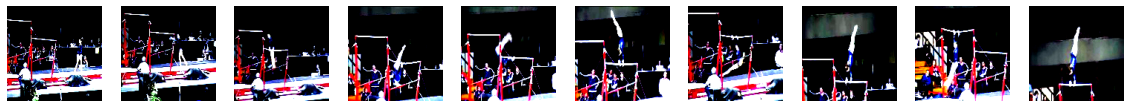

In [22]:
for i, a in enumerate(generate_loader):
#     print(a)
#     print(a[0].shape)
    if i == 16:
        caption = ""
        for wordidx in a[1][0].numpy()[1:-1]:
            caption += (" " + activity_vocab.idx2word[wordidx])
        caption = caption[1:]
        print("caption: {}".format(caption))
        src = a[0].squeeze().cuda()
        nopeak_mask = np.triu(np.ones((1, a[1][:,:-1].shape[1], a[1][:,:-1].shape[1])),k=1)
        nopeak_mask = Variable(torch.from_numpy(nopeak_mask) == 0).cuda()
        
        pred = model(src, a[1][:,:-1].cuda(), None, nopeak_mask)
        pred_caption = ""
        for wordidx in pred.max(2)[1][0].cpu().numpy():
            pred_caption += (" " + activity_vocab.idx2word[wordidx])
        print("prediction: {}".format(pred_caption))
        meteor_generated = round(nltk.translate.meteor_score.single_meteor_score(caption, pred_caption),4) * 100
        print(meteor_generated)
        
        pred2 = model2(src, a[1][:,:-1].cuda(), None, nopeak_mask)
        pred_caption2 = ""
        for wordidx in pred2.max(2)[1][0].cpu().numpy():
            pred_caption2 += (" " + activity_vocab.idx2word[wordidx])
        print("prediction: {}".format(pred_caption2))

#         pred_caption = generate_captions(model, src)
#         print("prediction model: {}".format(pred_caption))

#         pred_caption = generate_captions(model2, src)
#         print("prediction model 2: {}".format(pred_caption))

        fig = plt.figure(figsize=(20,10)) # figsize (width,height)
        for i, val in enumerate(a[0][0]):
            if i % 2 == 0:
                ax = plt.subplot(1,a[0].shape[1]/2,i/2+ 1) # (rows, cols, index)
                ax.imshow(val.numpy().transpose((1,2,0)))
                ax.axis("off")
#         fig.savefig("example_16", dpi=300)
        break
    

In [18]:
train_losses, val_losses, meteors, bleu1s, bleu4s = np.load("baseline_stats_nopeak.npy")

In [97]:
# plt.plot(train_losses)
# plt.plot(val_losses)

# plt.legend(["train", "val"])
# plt.title("loss curves")
# plt.xlabel("epoch")
# plt.ylabel("cross entropy loss")